In [1]:
import sys
from joblib import dump, load
sys.path.append("..")
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from pathlib import Path

from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg

import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *

import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
import common_vars as comv

import csv
import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
from feature_extraction import pytorch_models as pm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
# device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['tom_low','snare','hihat_closed','rim','synth_noise','clap','kick','hihat_open','tom_mid']

drum_df=pd.DataFrame(columns=["name","fc","cnnlstm","env+freq","consensus","stack_size"])

def model_loader(m,p):
    s=torch.load(p) 
    m.load_state_dict(s)
    m.to(device)
    return m

In [2]:

imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='../feature_extraction/models/fc/env_dvn_95_35.pt'
env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
state='../feature_extraction/models/fc/spec_fc_dvn_96.pt'
fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
state='../feature_extraction/models/cnn/clst_dvn_96_279.pt'
cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
state='../feature_extraction/models/fc/spec_fc_dvd_81.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNNLSTM_dvd(len_out=len(drum_groups))
state='../feature_extraction/models/cnn/clst_dvd_90_170.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
state='../feature_extraction/models/fc/freq_env_dvd_86_351.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)



In [5]:
#making graphs of models

from torchsummary import summary
import imp as imp
out,params= stackMaker(stack_size)
a= memToAud(out)
imp.reload(torchviz)
transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
env_feats=env_trans.call(transform_input)["feats"].to(device)
freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
spec_flat=torch.flatten(pitch_feats, start_dim=1)

outputEnvFreq=freq_env_model_dvd(freq_feats)
outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
outputFCDVD=dvd_fc(spec_flat)
outputE=env_model_dvn(env_feats)
outputSPECFC=fc_spec_model_dvn(spec_flat)
outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))


# summary(freq_env_model_dvd,freq_feats.shape)

model,x=freq_env_model_dvd,freq_feats
model,x=dvd_cnn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)
model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)




In [ ]:
# model,x=freq_env_model_dvd,freq_feats
# model=fc_spec_model_dvn
# model=  fc_spec_model_dvn
model,x=dvd_fc,pitch_feats.reshape(-1,1,20,20)
# model,x=cnn_model_dvn,pitch_feats.reshape(-1,1,20,20)
# model,x=dvd_cnn,pitch_feats.reshape(-1,1,20,20)
model

In [ ]:
x=summary(model,pitch_feats.reshape(1,20,20).shape)
summary?

env score 0.8940658569335938
fc_spec 0.0005671764956787229
o_cnn_spec 0.0001602107658982277
fc category synth_noise 
cnn category synth_noise 
env+freq clap
total consensus synth_noise
it took 1 iteration, stack size 2


/home/asalimi/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
../feature_extraction/pytorch_models.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=self.lsm(out)
../feature_extraction/pytorch_models.py:167: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=self.lsm(out)


<Figure size 864x216 with 0 Axes>

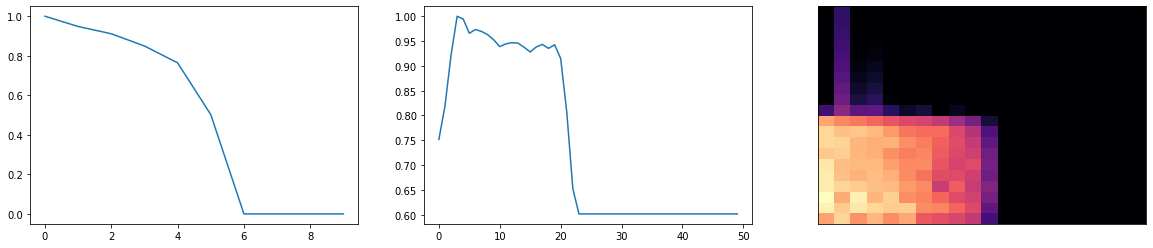

In [4]:

def evalSoundSlow(a):
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=0.5) or (o_e>0.5 and o_cnn_spec>0.7):
        print("env score",o_e)
        print("fc_spec",o_fc_spec)
        print("o_cnn_spec",o_cnn_spec)
        print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
        print("total consensus",cat_consensus)
        
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

def findDrum(stack_size=1,iteration=0):
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    return evalSoundSlow(a)
i=0
j=0
while i<10000000:
    i=i+1
    j=j+1
    stack_size=np.random.choice([2])
    (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
    if results!="not_found":
        print("it took %d iteration, stack size %d"%(j,stack_size))
        j=0

        break

fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)

plt.plot(env_feats.cpu())
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50].cpu())
ax=plt.subplot(1,3,3)
ft=pitch_feats.cpu()
ft=ft.numpy()
librosa.display.specshow(ft[0])

Audio(a,rate=sr, autoplay=True)

In [6]:
def evalSound(a,printing=False):
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)


#     outputEnvFreq=freq_env_model_dvd(freq_feats)
#     outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
#     outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
#     tote=outputE[0].item()+outputSPECFC[0][0].item()

#     gfc=drum_groups[torch.argmax(outputFCDVD).item()]
#     gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
#     genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
#     cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
#     if printing:
#         print(outputEnvFreq)
#         print(torch.argmax(outputEnvFreq).item())
#         print("env score",o_e)
#         print("fc_spec",o_fc_spec)
#         print("o_cnn_spec",o_cnn_spec)
#         print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
#         print("total consensus",cat_consensus)
#         return o_cnn_spec
    return o_fc_spec
out,params= stackMaker(stack_size)
def findDrum(stack_size=1,iteration=0):
    
    a= memToAud(out)
    return a,evalSound(a,printing=True)
i=0
a,sc=findDrum(stack_size,iteration=i)


# print(sc)
print(a,sc)
Audio(a,rate=sr, autoplay=True)

[0.00000000e+00 2.36851854e-13 5.40881711e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00] 3.3495191019028425e-05


In [7]:
def evalSound(a,printing=False):
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)


    outputEnvFreq=freq_env_model_dvd(freq_feats)
    outputCNNDVD=dvd_cnn(pitch_feats.reshape(-1,1,20,20))
    outputFCDVD=dvd_fc(spec_flat)
    outputE=env_model_dvn(env_feats)
    outputSPECFC=fc_spec_model_dvn(spec_flat)
    outputCNN= cnn_model_dvn(pitch_feats.reshape(-1,1,20,20))
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if printing:
        print(tote)
        print(outputEnvFreq)
        print(torch.argmax(outputEnvFreq).item())
        print("env score",o_e)
        print("fc_spec",o_fc_spec)
        print("o_cnn_spec",o_cnn_spec)
        print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
        print("total consensus",cat_consensus)
        return o_cnn_spec
    return o_cnn_spec


def findDrum(stack_size=1,iteration=0):
    
    a= memToAud(out)
    return a,evalSound(a,printing=True)


In [8]:
stack_size=1
#measure variation
out,params= stackMaker(stack_size)

j_shape=10
all_rows = []
while len(all_rows) < 50:
    one_row= np.zeros(10)
    out,params= stackMaker(stack_size)
    for j in range(j_shape):
        out=paramToSound(params)
        a = memToAud(out)
        one_row[j]=evalSound(a)
#     print(np.average(one_row))
    if np.average(one_row)>0: all_rows.append(one_row); print(str(len(all_rows))+"\r",end='')
    
all_rows=np.array(all_rows)
df = pd.DataFrame(all_rows)


../feature_extraction/pytorch_models.py:189: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out=self.lsm(out)


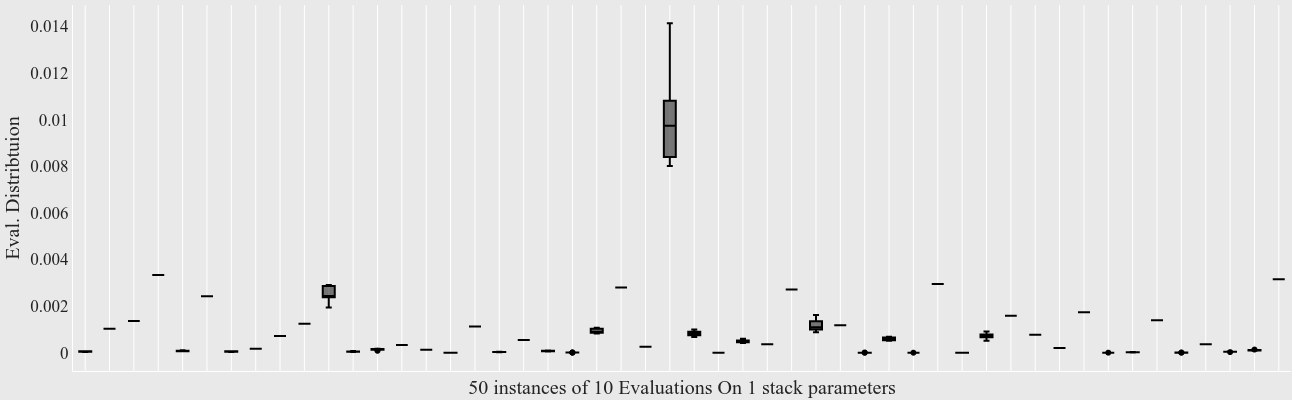

In [42]:


import plotly.graph_objects as go
import numpy as np
from kaleido.scopes.plotly import PlotlyScope
scope = PlotlyScope()
N = 50    # Number of boxes

# generate an array of rainbow colors by fixing the saturation and lightness of the HSL
# representation of colour and marching around the hue.
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour.
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
fig = go.Figure(data=[go.Box(
    y=row,
    marker_color="black",
    ) for i,row in enumerate(all_rows[0:N])])

# format the layout
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(zeroline=False, gridcolor='white'),
#     yaxis_type="log",
    paper_bgcolor='rgb(233,233,233)',
    plot_bgcolor='rgb(233,233,233)',
    showlegend=False,
    template="seaborn",
    width=900,height=400,
    font_family="Times New Roman",
    margin=dict(l=0, t=5,r=1,  b=1),
    font_size=17,
    
)
fig.update_xaxes(title_text="%d instances of 10 Evaluations On %d stack parameters"%(N,stack_size))
fig.update_yaxes(title_text='Eval. Distribtuion ',
                   
#                     dtick=1,
                    )
fig.update_xaxes(showgrid=True,zeroline=False,)
fig.update_yaxes(showgrid=False,zeroline=False,)

fig.show()
with open("eval_stability_stacksize%d.pdf"%stack_size, "wb") as f:
    f.write(scope.transform(fig, format="pdf",width=1000,height=400,))
